In [61]:
import numpy as np
import seaborn as sns
import torch
import pandas as pd
import os
import matplotlib.pyplot as plt
import torchdeepretina as tdr
import tqdm

In [2]:
pd.set_option('display.max_columns', 100)
pd.set_option("display.max_rows", 500)

In [57]:
prepath = "~/src/torch-deep-retina/training_scripts/"
intr_folders = ["intrnrn", "intrnrns_bests" ] #, "intrnrn2lay2x1_bests", "intrnrn2lay1x1_bests", "intrnrn2x2_bests"]
#intr_folders = ["intrnrn_bests", "intrnrns_bests", "intrnrn2lay2x1_bests", "intrnrn2lay1x1_bests", "intrnrn2x2_bests"]
#intr_folders = ["intrnrn", "intrnrns_bests"]
max_layers = 3
max_chans = 3
aft_nonlin = False
intr_acc_type = "val_acc"
model_folders = ["convgc_bests", "convgc_moreseeds"]
intr_csv = "normalized_abs_intr_data.csv"
model_csv = "gc_data.csv"
cell_types = {"amacrine", "bipolar", "unk"}
intr_stim_type = "boxes"
sort_by = "cor" # alternatively "abs_cor"

In [52]:
# First get performance df
intr_df = pd.read_csv(os.path.join(prepath, intr_folders[0], model_csv), sep="!")
if len(intr_folders)>1:
    for intr_folder in intr_folders[1:]:
        try:
            intr_df = intr_df.append(pd.read_csv(os.path.join(prepath, intr_folder, model_csv), sep="!"))
        except:
            print("Failed to load", os.path.join(prepath, intr_folder, model_csv))
    
cols = ["save_folder", "dataset", "stim_type", "cells", "n_layers", intr_acc_type, "chans"]
if "n_layers" not in set(intr_df.columns):
    if intr_acc_type not in intr_df.columns:
        intr_df[intr_acc_type] = intr_df["cor"]
        del intr_df["cor"]
    missing_cols = set(cols)-set(intr_df.columns)
    for col in missing_cols: intr_df[col] = "foo"
    for folder in set(intr_df["save_folder"]):
        exp_folder = folder.split("_")[0]
        hyps = tdr.io.get_hyps(os.path.join("~/src/torch-deep-retina/training_scripts/",exp_folder, folder))
        for col in missing_cols:
            try:
                intr_df.loc[intr_df["save_folder"]==folder,col] = str(hyps[col])
            except:
                print(folder, "coult not find", col)
    intr_df["n_layers"] = intr_df["n_layers"].astype("int")
                
m = np.max(list(set(intr_df["n_layers"].astype("int"))))
if max_layers is not None and max_layers > m: max_layers = m

if max_chans is not None:
    intr_df["l1_chan"] = intr_df.apply(lambda x: int(x.chans[1:-1].split(",")[0]), axis=1)
    intr_df["l2_chan"] = intr_df.apply(lambda x: int(x.chans[1:-1].split(",")[-1]), axis=1)
    intr_df = intr_df.loc[(intr_df["l1_chan"]<=max_chans)]

intr_df = intr_df[cols]
intr_df["save_folder"] = intr_df.apply(lambda x: x.save_folder.split("/")[-1], axis=1)
intr_df["cells"] = intr_df["cells"].astype("string")
intr_df["cells"] = intr_df.apply(lambda x: int(x.cells) if "[" not in x.cells else int(x.cells[1:-1]), axis=1).astype("int")
intr_df["dataset"] = intr_df.apply(lambda x: x.dataset+".h5", axis=1)

intr_df["intr_cell_id"] = intr_df["dataset"] + intr_df["cells"].astype("string")
intr_df = intr_df.loc[intr_df["stim_type"]==intr_stim_type]
print("Save Folders:", len(set(intr_df["save_folder"])))

# take only best peforming interneuron
#dups = ["dataset", "cells"]
#intr_df = intr_df.sort_values(by=intr_acc_type, ascending=False).drop_duplicates(dups)
#print(len(set(intr_df["save_folder"])))

Save Folders: 891


In [53]:
try:
    intr_cors = pd.read_csv(os.path.join(prepath, intr_folders[0], intr_csv), sep="!")
except:
    intr_cors = pd.read_csv(os.path.join(prepath, intr_folders[0], "intr_data.csv"), sep="!")
if  len(intr_folders)>1:
    for intr_folder in intr_folders[1:]:
        try:
            intr_cors = intr_cors.append(pd.read_csv(os.path.join(prepath, intr_folder, intr_csv), sep="!"))
        except:
            intr_cors = intr_cors.append(pd.read_csv(os.path.join(prepath, intr_folder, "intr_data.csv"), sep="!"))
        
intr_cors["intr_cell_id"] = intr_cors["cell_file"] + intr_cors["cell_idx"].astype("string")
intr_cors["save_folder"] = intr_cors.apply(lambda x: x.save_folder.split("/")[-1], axis=1)
intr_cors["cell_idx"] = intr_cors["cell_idx"].astype("int")
del intr_cors["stim_type"]
intr_cors = intr_cors.loc[intr_cors["intr_stim"]==intr_stim_type]

save_folders = set(intr_cors["save_folder"])
intr_df = intr_df.loc[intr_df["save_folder"].isin(save_folders)]

dups = ["dataset", "cells"]
intr_df = intr_df.sort_values(by=intr_acc_type, ascending=False).drop_duplicates(dups)

save_folders = set(intr_df["save_folder"])
intr_cors = intr_cors.loc[intr_cors["save_folder"].isin(save_folders)]

intr_cors = intr_cors.merge(intr_df, on="save_folder", how="inner")
intr_cors["abs_cor"] = np.abs(intr_cors["cor"])

# Isolate interneuron cell types
intr_cors = intr_cors.loc[intr_cors["cell_type"].isin(cell_types)]

# Remove possibility of using model trained on interneuron recording for correlations
print("All Rows:", len(intr_cors))
intr_cors = intr_cors.loc[((intr_cors["cell_file"]!=intr_cors["dataset"])|(intr_cors["cell_idx"]!=intr_cors["cells"]))]
print("No Same Train Rows:", len(intr_cors))
# Limit layer count of model
if max_layers is not None:
    intr_cors = intr_cors.loc[(intr_cors["n_layers"]<=max_layers)]
    print("Limited Max Layers:", len(intr_cors))
    
# Select "outputs" layer (which is after the nonlinearity) or last layer before nonlinearity
# In the case that we are not using the outputs layer, the last layer could vary by model type.
# Thus we need to loop through possible combinations of save_folders and the last layer name
intr_cors.loc[intr_cors["layer"]=="outputs", "layer"] = "100" if aft_nonlin else "-1"
intr_cors["sort_layer"] = intr_cors.apply(lambda x: int(x.layer.split(".")[-1]), axis=1)
# isolates all save_folder, last layer pairs
temp = intr_cors.sort_values(by="sort_layer", ascending=False).drop_duplicates("save_folder")
print("N Save Folders", len(temp))
for i in range(len(temp["save_folder"])):
    folder = temp.iloc[i]["save_folder"]
    layer = temp.iloc[i]["layer"]
    intr_cors = intr_cors.loc[(intr_cors["save_folder"]!=folder)|((intr_cors["save_folder"]==folder)&(intr_cors["layer"]==layer))]

dups = ["cell_file", "cell_idx", "save_folder"]
intr_cors = intr_cors.drop_duplicates(dups)
print("All Length:", len(intr_cors))
dups = ["cell_file", "cell_idx"]
best_intr_cors = intr_cors.sort_values(by=sort_by, ascending=False).drop_duplicates(dups).reset_index()
print("Bests Length:", len(best_intr_cors))
best_intr_cors.head()


All Rows: 12288
No Same Train Rows: 12032
Limited Max Layers: 12032
N Save Folders 48
All Length: 2256
Bests Length: 48


,index,cell_file,cell_idx,cell_type,layer,chan,row,col,cor,xshift,yshift,tshift,abs_cor,intr_stim,save_folder,normalized,intr_cell_id_x,dataset,stim_type,cells,n_layers,test_acc,chans,intr_cell_id_y,sort_layer
0,8506,bipolars_late_2012.h5,0,bipolar,sequential.8,0,1,4,0.879537,0,0,0.0,0.879537,boxes,"intrnrn_319_n_layers3_chans[2, 2]_datasetbipol...",True,bipolars_late_2012.h50,bipolars_late_2012.h5,boxes,3,3,0.494957,"[2, 2]",bipolars_late_2012.h53,8
1,7616,bipolars_late_2012.h5,1,bipolar,sequential.8,0,0,2,0.865258,0,0,0.0,0.865258,boxes,"intrnrn_508_n_layers3_chans[3, 3]_datasetamacr...",True,bipolars_late_2012.h51,amacrines_late_2012.h5,boxes,11,3,0.718098,"[3, 3]",amacrines_late_2012.h511,8
2,1663,amacrines_late_2012.h5,11,amacrine,sequential.8,0,0,2,0.865224,0,0,0.0,0.865224,boxes,"intrnrn_328_n_layers3_chans[3, 3]_datasetbipol...",True,amacrines_late_2012.h511,bipolars_late_2012.h5,boxes,1,3,0.717570,"[3, 3]",bipolars_late_2012.h51,8
3,5547,bipolars_late_2012.h5,3,bipolar,sequential.4,0,5,6,0.848480,0,0,0.0,0.848480,boxes,"intrnrn_24_n_layers2_chans[3, 3]_datasetbipola...",True,bipolars_late_2012.h53,bipolars_late_2012.h5,boxes,0,2,0.245294,"[3, 3]",bipolars_late_2012.h50,4
4,5551,bipolars_late_2012.h5,2,bipolar,sequential.4,0,7,9,0.840714,0,0,0.0,0.840714,boxes,"intrnrn_24_n_layers2_chans[3, 3]_datasetbipola...",True,bipolars_late_2012.h52,bipolars_late_2012.h5,boxes,0,2,0.245294,"[3, 3]",bipolars_late_2012.h50,4


## Intrneuron Histogram

In [54]:
labelsize = 35
ticksize = 30
titlesize = 40
legendsize = 20

Text(0.5, 1.0, 'Intr - Intr')

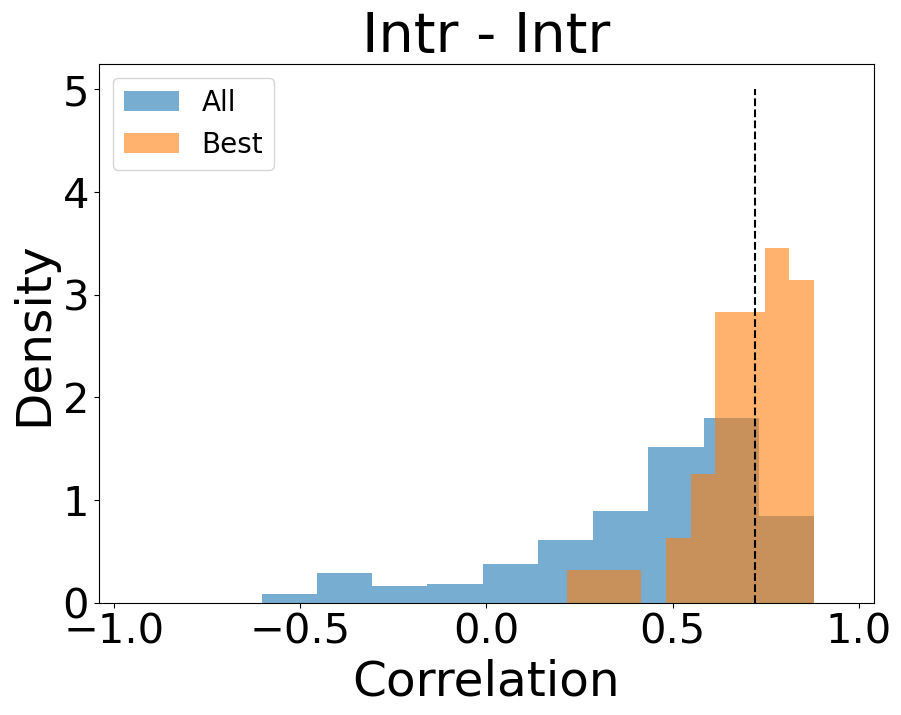

In [55]:
fig = plt.figure(figsize=(10,7))
plt.hist(intr_cors["cor"], label="All", density=True, alpha=0.6)
plt.hist(best_intr_cors['cor'], label="Best", density=True, alpha=0.6)

median = np.median(best_intr_cors["cor"])
max_val = 6
plt.plot(np.ones(max_val)*median, np.arange(max_val), "k--")

plt.xlabel("Correlation", fontsize=labelsize)
plt.ylabel("Density", fontsize=labelsize)
plt.xticks([i*0.1 for i in range(-10, 11, 5)], fontsize=ticksize)
plt.yticks([i*0.1 for i in range(0, 51, 10)], fontsize=ticksize)
plt.xlim([-1.04, 1.04])
plt.legend(loc="upper left", fontsize=legendsize)
plt.title("Intr - Intr", fontsize=titlesize)

Text(0.5, 1.0, 'Intr - Intr Prep')

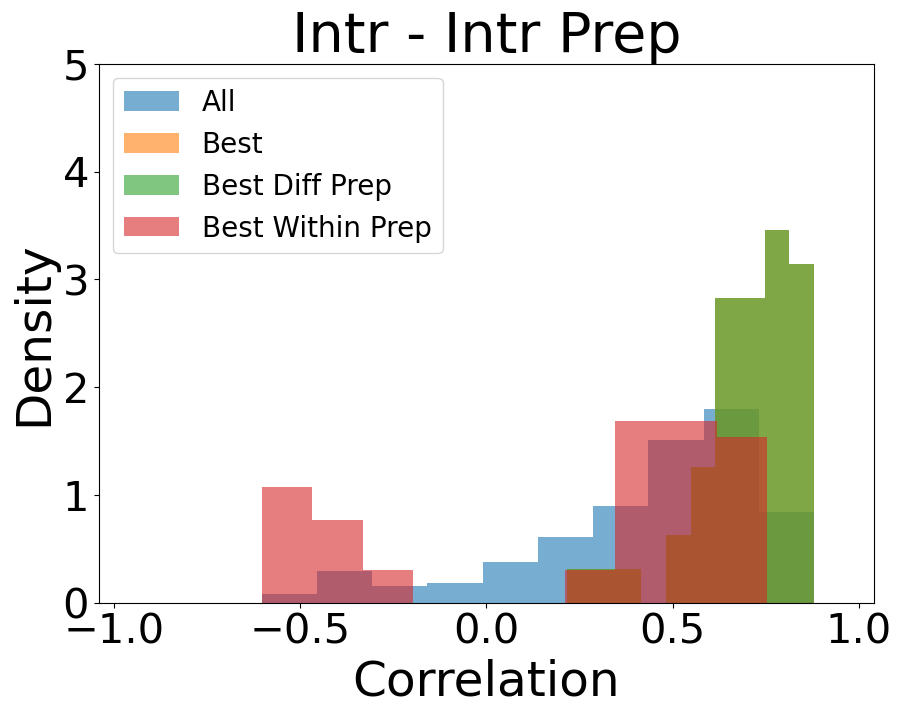

In [56]:
fig = plt.figure(figsize=(10,7))
plt.hist(intr_cors["cor"], label="All", density=True, alpha=0.6)
plt.hist(best_intr_cors['cor'], label="Best", density=True, alpha=0.6)

dups = ["cell_file", "cell_idx"]
temp = intr_cors.loc[intr_cors["cell_file"]!=intr_cors["dataset"]].sort_values(by="cor").drop_duplicates(dups)
plt.hist(best_intr_cors['cor'], label="Best Diff Prep", density=True, alpha=0.6)

temp = intr_cors.loc[intr_cors["cell_file"]==intr_cors["dataset"]].sort_values(by="cor").drop_duplicates(dups)
plt.hist(temp['cor'], label="Best Within Prep", density=True, alpha=0.6)

plt.xlabel("Correlation", fontsize=labelsize)
plt.ylabel("Density", fontsize=labelsize)
plt.xticks([i*0.1 for i in range(-10, 11, 5)], fontsize=ticksize)
plt.yticks([i*0.1 for i in range(0, 51, 10)], fontsize=ticksize)
plt.xlim([-1.04, 1.04])
plt.legend(fontsize=legendsize)
plt.title("Intr - Intr Prep", fontsize=titlesize)

<AxesSubplot:xlabel='val_acc', ylabel='cor'>

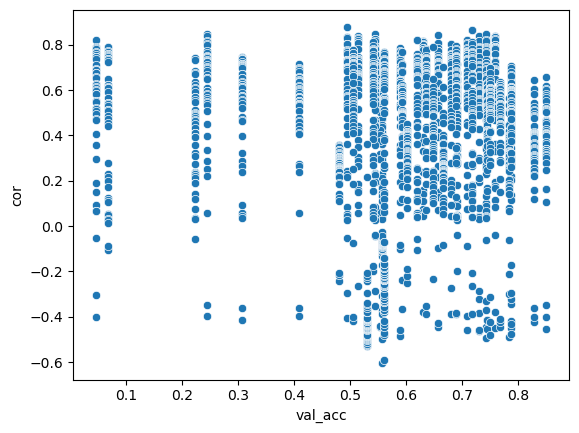

In [44]:
sns.scatterplot(x="val_acc", y="cor", data=intr_cors)

## Model Histogram

In [45]:
model_data = pd.read_csv(os.path.join(prepath, model_folders[0], "model_data.csv"), sep="!")
path = os.path.join(prepath, "similarity_csvs/{}_{}_all_abs_chans_similarities.csv".format(model_folders[0], model_folders[0]))
conv_cors = pd.read_csv(path,sep="!")

if len(model_folders)>1:
    for folder in model_folders[1:]:
        model_data = model_data.append(
            pd.read_csv(os.path.join(prepath, folder, "model_data.csv"), sep="!")
        )
        path = os.path.join(prepath, "similarity_csvs/{}_{}_all_abs_chans_similarities.csv".format(folder, folder))
        conv_cors = conv_cors.append( pd.read_csv(path,sep="!") )
        
model_data = model_data[["save_folder", "dataset", "stim_type"]]
conv_cors = conv_cors.merge(model_data, how="inner", left_on="model1", right_on="save_folder")

if len(conv_cors)==0:
    model_data["save_folder"] = model_data.apply(lambda x: ("./" + x.save_folder).split("/")[-1], axis=1)
    conv_cors = pd.read_csv(path,sep="!")
    conv_cors["model1"] = conv_cors.apply(lambda x: ("./" + x.model1).split("/")[-1], axis=1)
    conv_cors["model2"] = conv_cors.apply(lambda x: ("./" + x.model2).split("/")[-1], axis=1)
    conv_cors = conv_cors.merge(model_data, how="inner", left_on="model1", right_on="save_folder")
    
model_data.columns = [c+"2" for c in model_data.columns]
conv_cors = conv_cors.merge(model_data, how="inner", left_on="model2", right_on="save_folder2")
conv_cors = conv_cors.loc[(conv_cors["m1_layer"]!="sequential.8")&(conv_cors["m2_layer"]!="sequential.8")]
conv_cors = conv_cors.loc[(conv_cors["model1"]!=conv_cors["model2"])]

conv_cors["prep1"] = conv_cors["stim_type"] + conv_cors["dataset"]
conv_cors["prep2"] = conv_cors["stim_type2"] + conv_cors["dataset2"]
#conv_cors["prep1"] = conv_cors.apply(lambda x: x.model1.split("stim_type")[-1].split("_")[0] + x.model1.split("dataset")[-1].split("_")[0], axis=1)
#conv_cors["prep2"] = conv_cors.apply(lambda x: x.model2.split("stim_type")[-1].split("_")[0] + x.model2.split("dataset")[-1].split("_")[0], axis=1)
#conv_cors = conv_cors.loc[conv_cors['cor_type']=="chan_act"]
conv_cors["abs_cor"] = np.abs(conv_cors["cor"])
dups = ["model1", "m1_layer", "chan1", "model2", "m2_layer", "chan2"]
conv_cors = conv_cors.sort_values(by="abs_cor", ascending=False).drop_duplicates(dups).reset_index(drop=True)
dups = ["model1", "m1_layer", "chan1", "model2"]
best_conv_cors = conv_cors.sort_values(by="cor", ascending=False).drop_duplicates(dups).reset_index(drop=True)
best_conv_cors.head()

,chan1,chan2,cor,cor_type,m1_layer,m2_layer,model1,model2,xy_coord,save_folder,dataset,stim_type,save_folder2,dataset2,stim_type2,prep1,prep2,abs_cor
0,2,2,0.998609,max_act,sequential.0,sequential.0,convgc_moreseeds/convgc_moreseeds_6_seed456783...,convgc_moreseeds/convgc_moreseeds_9_seed567894...,"(18, 18)",convgc_moreseeds/convgc_moreseeds_6_seed456783...,15-10-07,whitenoise,convgc_moreseeds/convgc_moreseeds_9_seed567894...,15-10-07,whitenoise,whitenoise15-10-07,whitenoise15-10-07,0.998609
1,2,2,0.998609,max_act,sequential.0,sequential.0,convgc_moreseeds/convgc_moreseeds_9_seed567894...,convgc_moreseeds/convgc_moreseeds_6_seed456783...,"(18, 18)",convgc_moreseeds/convgc_moreseeds_9_seed567894...,15-10-07,whitenoise,convgc_moreseeds/convgc_moreseeds_6_seed456783...,15-10-07,whitenoise,whitenoise15-10-07,whitenoise15-10-07,0.998609
2,0,2,0.998341,max_act,sequential.0,sequential.0,convgc_moreseeds/convgc_moreseeds_29_seed56789...,convgc_moreseeds/convgc_moreseeds_28_seed34567...,"(18, 18)",convgc_moreseeds/convgc_moreseeds_29_seed56789...,15-11-21b,whitenoise,convgc_moreseeds/convgc_moreseeds_28_seed34567...,15-11-21b,whitenoise,whitenoise15-11-21b,whitenoise15-11-21b,0.998341
3,4,1,0.998184,max_act,sequential.0,sequential.0,convgc_moreseeds/convgc_moreseeds_25_seed23456...,convgc_moreseeds/convgc_moreseeds_26_seed45678...,"(18, 18)",convgc_moreseeds/convgc_moreseeds_25_seed23456...,15-11-21b,whitenoise,convgc_moreseeds/convgc_moreseeds_26_seed45678...,15-11-21b,whitenoise,whitenoise15-11-21b,whitenoise15-11-21b,0.998184
4,1,4,0.998099,max_act,sequential.0,sequential.0,convgc_moreseeds/convgc_moreseeds_26_seed45678...,convgc_moreseeds/convgc_moreseeds_25_seed23456...,"(18, 18)",convgc_moreseeds/convgc_moreseeds_26_seed45678...,15-11-21b,whitenoise,convgc_moreseeds/convgc_moreseeds_25_seed23456...,15-11-21b,whitenoise,whitenoise15-11-21b,whitenoise15-11-21b,0.998099


## Model Histogram

Text(0.5, 1.0, 'Model - Model Diff Prep')

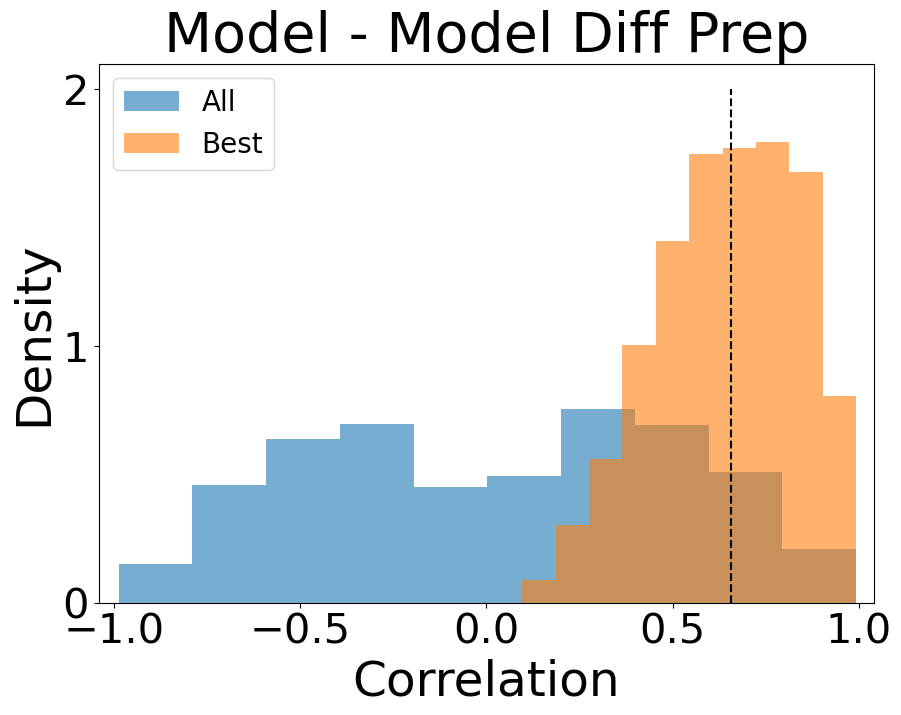

In [25]:
fig = plt.figure(figsize=(10,7))
conv_df = conv_cors.loc[(conv_cors["prep1"]!=conv_cors["prep2"])]
plt.hist(conv_df['cor'], label="All", alpha=0.6, density=True)

conv_df = best_conv_cors.loc[(best_conv_cors["prep1"]!=best_conv_cors["prep2"])]
plt.hist(conv_df['cor'], label="Best", alpha=0.6, density=True)

median = np.median(conv_df["cor"])
max_val = 3
plt.plot(np.ones(max_val)*median, np.arange(max_val), "k--")


plt.xlabel("Correlation", fontsize=labelsize)
plt.ylabel("Density", fontsize=labelsize)
plt.xticks([i*0.1 for i in range(-10, 11, 5)], fontsize=ticksize)
plt.yticks([i*0.1 for i in range(0, 21, 10)], fontsize=ticksize)
plt.xlim([-1.04, 1.04])
plt.legend(fontsize=legendsize)
plt.title("Model - Model Diff Prep", fontsize=titlesize)

Text(0.5, 1.0, 'Model - Model Same Prep')

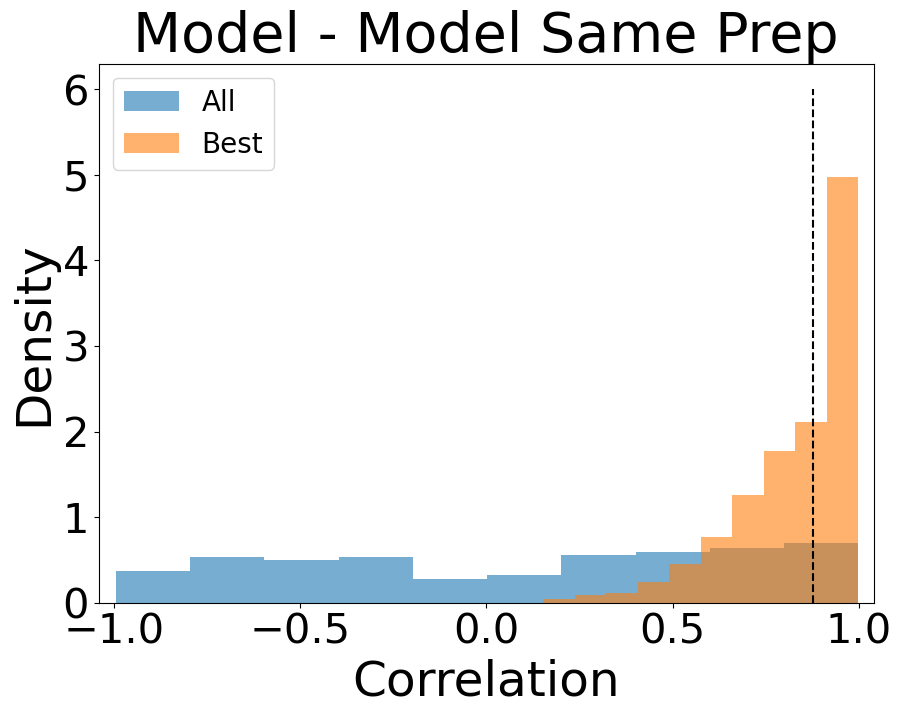

In [26]:
fig = plt.figure(figsize=(10,7))
conv_df = conv_cors.loc[(conv_cors["prep1"]==conv_cors["prep2"])]
plt.hist(conv_df['cor'], label="All", alpha=0.6, density=True)

conv_df = best_conv_cors.loc[(best_conv_cors["prep1"]==best_conv_cors["prep2"])]
plt.hist(conv_df['cor'], label="Best", alpha=0.6, density=True)

median = np.median(conv_df["cor"])
max_val = 7
plt.plot(np.ones(max_val)*median, np.arange(max_val), "k--")


plt.xlabel("Correlation", fontsize=labelsize)
plt.ylabel("Density", fontsize=labelsize)
plt.xticks([i*0.1 for i in range(-10, 11, 5)], fontsize=ticksize)
plt.yticks([i*0.1 for i in range(0, 61, 10)], fontsize=ticksize)
plt.xlim([-1.04, 1.04])
plt.legend(fontsize=legendsize)
plt.title("Model - Model Same Prep", fontsize=titlesize)

## Intr to Conv Prep

In [58]:
model_data = pd.read_csv(os.path.join(prepath, model_folders[0], "model_data.csv"), sep="!")
path = os.path.join(prepath, "{}/{}".format(model_folders[0],intr_csv))
cross_cors = pd.read_csv(path,sep="!")
if len(model_folders)>1:
    for folder in model_folders[1:]:
        model_data = model_data.append(
            pd.read_csv(os.path.join(prepath, folder, "model_data.csv"), sep="!")
        )
        path = os.path.join(prepath, "{}/{}".format(folder,intr_csv))
        cross_cors = cross_cors.append(pd.read_csv(path,sep="!"))
model_data = model_data[["save_folder", "dataset", "stim_type"]]

cross_cors = cross_cors.loc[cross_cors["cell_type"].isin(cell_types)]
del cross_cors["stim_type"]
cross_cors = cross_cors.merge(model_data, how="inner", on="save_folder")
cross_cors["prep"] = cross_cors["stim_type"] + cross_cors["dataset"]

cross_cors["abs_cor"] = np.abs(cross_cors["cor"])
layers = {"sequential.0", "sequential.4"}
cross_cors = cross_cors.loc[cross_cors["layer"].isin(layers)]
dups = ["cell_file", "cell_idx", "save_folder", "layer", "chan"]
#dups = ["model1", "m1_layer", "chan1", "model2"]
cross_cors = cross_cors.sort_values(by="cor", ascending=False).drop_duplicates(dups).reset_index(drop=True)
cross_cors.head()

,cell_file,cell_idx,cell_type,layer,chan,row,col,cor,xshift,yshift,tshift,abs_cor,intr_stim,save_folder,normalized,dataset,stim_type,prep
0,amacrines_late_2012.h5,3,amacrine,sequential.0,6,16,27,0.895314,0,0,0,0.895314,boxes,convgc_bests/convgc_57_dataset15-11-21a_stim_t...,True,15-11-21a,whitenoise,whitenoise15-11-21a
1,amacrines_late_2012.h5,3,amacrine,sequential.0,4,16,27,0.886322,0,0,0,0.886322,boxes,convgc_moreseeds/convgc_moreseeds_18_seed34567...,True,15-11-21a,whitenoise,whitenoise15-11-21a
2,amacrines_late_2012.h5,3,amacrine,sequential.0,0,16,27,0.870524,0,0,0,0.870524,boxes,convgc_moreseeds/convgc_moreseeds_16_seed45678...,True,15-11-21a,whitenoise,whitenoise15-11-21a
3,amacrines_late_2012.h5,3,amacrine,sequential.0,7,16,27,0.863589,0,0,0,0.863589,boxes,convgc_moreseeds/convgc_moreseeds_19_seed56789...,True,15-11-21a,whitenoise,whitenoise15-11-21a
4,amacrines_late_2012.h5,3,amacrine,sequential.0,6,17,20,0.856155,0,0,0,0.856155,boxes,convgc_moreseeds/convgc_moreseeds_9_seed567894...,True,15-10-07,whitenoise,whitenoise15-10-07


In [59]:
dups = ["cell_file", "cell_idx", "save_folder"]
#dups = ["model1", "m1_layer", "chan1", "model2"]
best_cross_cors = cross_cors.sort_values(by=sort_by, ascending=False).drop_duplicates(dups).reset_index(drop=True)

## Intr to Model All

Text(0.5, 1.0, 'Intr - Model')

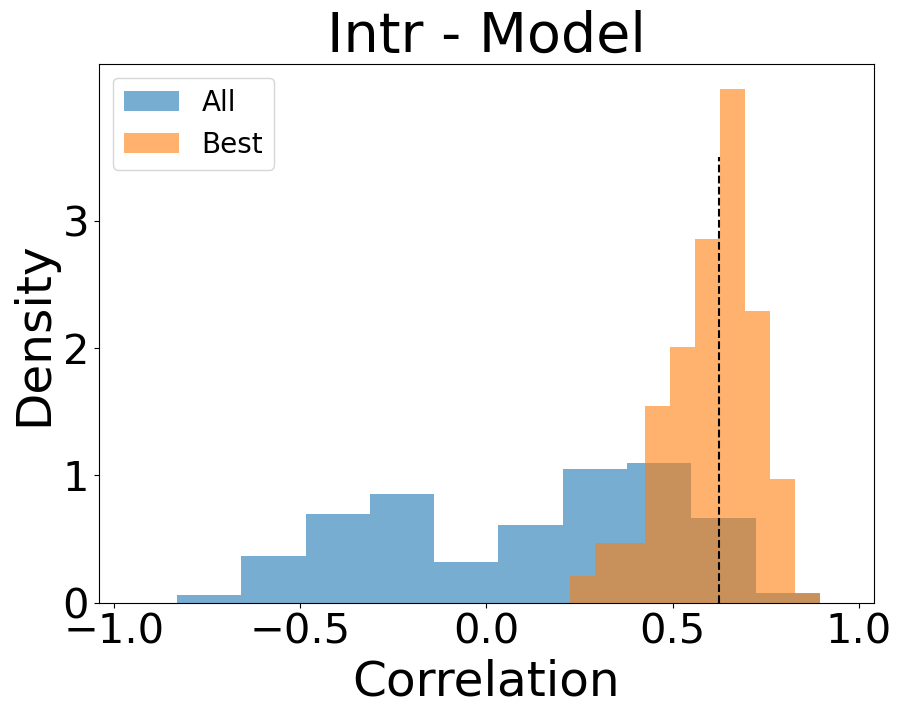

In [60]:
fig = plt.figure(figsize=(10,7))

plt.hist(cross_cors['cor'], label="All", density=True, alpha=0.6)
plt.hist(best_cross_cors['cor'], label="Best", density=True, alpha=0.6)

median = np.median(best_cross_cors["cor"])
max_val = 3.5
plt.plot([median, median], [0,max_val], "k--")


plt.xlabel("Correlation", fontsize=labelsize)
plt.ylabel("Density", fontsize=labelsize)
plt.xticks([i*0.1 for i in range(-10, 11, 5)], fontsize=ticksize)
plt.yticks([i*0.1 for i in range(0, 31, 10)], fontsize=ticksize)
plt.xlim([-1.04, 1.04])
plt.legend(fontsize=legendsize)
plt.title("Intr - Model", fontsize=titlesize)

## Intr to Model Bests

In [30]:
#dups = ['conv_model','intr_model']
#cross_bests = cross_cors.sort_values(by="cor",ascending=False).drop_duplicates(dups)
#plt.hist(cross_bests['cor'])

## All Together

In [96]:
alpha = 0.6
density = True

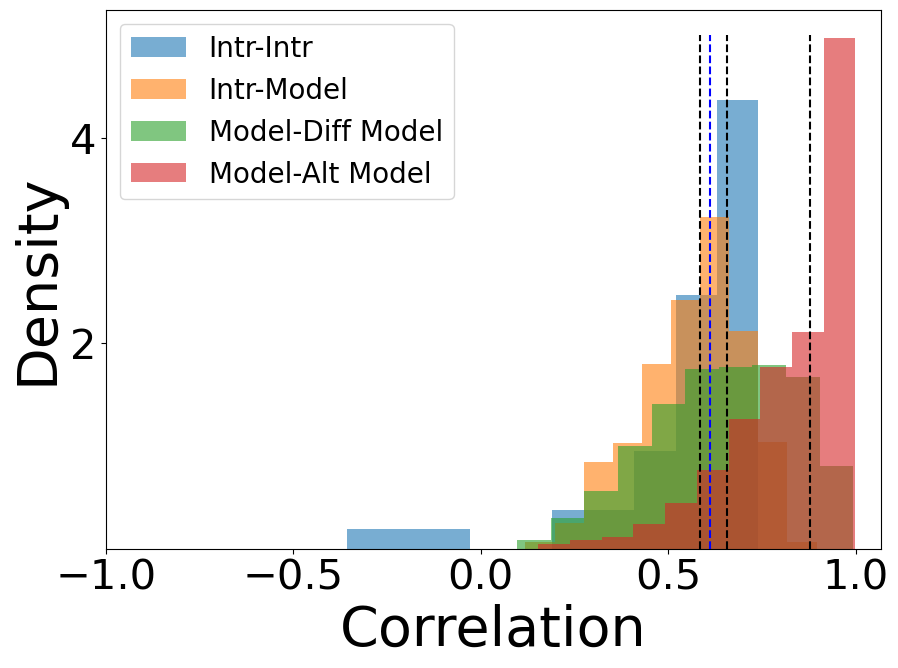

In [142]:
fig = plt.figure(figsize=(10,7))

# Intr-Intr
plt.hist(best_intr_cors["cor"], alpha=alpha, density=density, label="Intr-Intr")
median = np.median(best_intr_cors["cor"])
max_val = 5
plt.plot([median, median], [0,max_val], "--", color="blue")


# Intr-Model
plt.hist(best_cross_cors["cor"], alpha=alpha, density=density, label="Intr-Model")
median = np.median(best_cross_cors["cor"])
max_val = 5
plt.plot([median, median], [0,max_val], "--", color="orange")

# Model-Model Diff Prep
conv_df = best_conv_cors.loc[(best_conv_cors['model1']!=best_conv_cors['model2'])&(best_conv_cors["prep1"]!=best_conv_cors["prep2"])]
plt.hist(conv_df["cor"], alpha=alpha, density=density, label="Model-Diff Model")
median = np.median(conv_df["cor"])
max_val = 5
plt.plot([median, median], [0,max_val], "--", color="orange")

# Model-Model Same Prep
conv_df = best_conv_cors.loc[(best_conv_cors['model1']!=best_conv_cors['model2'])&(best_conv_cors["prep1"]==best_conv_cors["prep2"])]
if len(conv_df)>0:
    plt.hist(conv_df["cor"], alpha=alpha, density=density, label="Model-Alt Model")
    median = np.median(conv_df["cor"])
    max_val = 5
    plt.plot([median, median], [0,max_val], "k--")

plt.xlabel("Correlation", fontsize=40)
plt.ylabel("Density", fontsize=40)
plt.legend(fontsize=20)

plt.xticks([i*0.1 for i in range(-10, 11, 5)], fontsize=30)
plt.yticks([i*0.1 for i in range(20, 56, 20)], fontsize=30)

plt.show()

In [98]:
conv_cors

,chan1,chan2,cor,cor_type,m1_layer,m2_layer,model1,model2,xy_coord,save_folder,dataset,stim_type,save_folder2,dataset2,stim_type2,prep1,prep2,abs_cor
0,2,2,0.998609,max_act,sequential.0,sequential.0,convgc_moreseeds/convgc_moreseeds_6_seed456783...,convgc_moreseeds/convgc_moreseeds_9_seed567894...,"(18, 18)",convgc_moreseeds/convgc_moreseeds_6_seed456783...,15-10-07,whitenoise,convgc_moreseeds/convgc_moreseeds_9_seed567894...,15-10-07,whitenoise,whitenoise15-10-07,whitenoise15-10-07,0.998609
1,2,2,0.998609,max_act,sequential.0,sequential.0,convgc_moreseeds/convgc_moreseeds_9_seed567894...,convgc_moreseeds/convgc_moreseeds_6_seed456783...,"(18, 18)",convgc_moreseeds/convgc_moreseeds_9_seed567894...,15-10-07,whitenoise,convgc_moreseeds/convgc_moreseeds_6_seed456783...,15-10-07,whitenoise,whitenoise15-10-07,whitenoise15-10-07,0.998609
2,0,2,0.998341,max_act,sequential.0,sequential.0,convgc_moreseeds/convgc_moreseeds_29_seed56789...,convgc_moreseeds/convgc_moreseeds_28_seed34567...,"(18, 18)",convgc_moreseeds/convgc_moreseeds_29_seed56789...,15-11-21b,whitenoise,convgc_moreseeds/convgc_moreseeds_28_seed34567...,15-11-21b,whitenoise,whitenoise15-11-21b,whitenoise15-11-21b,0.998341
3,4,1,0.998184,max_act,sequential.0,sequential.0,convgc_moreseeds/convgc_moreseeds_25_seed23456...,convgc_moreseeds/convgc_moreseeds_26_seed45678...,"(18, 18)",convgc_moreseeds/convgc_moreseeds_25_seed23456...,15-11-21b,whitenoise,convgc_moreseeds/convgc_moreseeds_26_seed45678...,15-11-21b,whitenoise,whitenoise15-11-21b,whitenoise15-11-21b,0.998184
4,1,4,0.998099,max_act,sequential.0,sequential.0,convgc_moreseeds/convgc_moreseeds_26_seed45678...,convgc_moreseeds/convgc_moreseeds_25_seed23456...,"(18, 18)",convgc_moreseeds/convgc_moreseeds_26_seed45678...,15-11-21b,whitenoise,convgc_moreseeds/convgc_moreseeds_25_seed23456...,15-11-21b,whitenoise,whitenoise15-11-21b,whitenoise15-11-21b,0.998099
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230395,6,3,-0.017722,max_act,sequential.0,sequential.4,convgc_moreseeds/convgc_moreseeds_14_seed56789...,convgc_moreseeds/convgc_moreseeds_27_seed12345...,"(18, 18)",convgc_moreseeds/convgc_moreseeds_14_seed56789...,15-11-21a,naturalscene,convgc_moreseeds/convgc_moreseeds_27_seed12345...,15-11-21b,whitenoise,naturalscene15-11-21a,whitenoise15-11-21b,0.017722
230396,4,1,0.017379,max_act,sequential.4,sequential.4,convgc_moreseeds/convgc_moreseeds_10_seed23456...,convgc_moreseeds/convgc_moreseeds_29_seed56789...,"(13, 13)",convgc_moreseeds/convgc_moreseeds_10_seed23456...,15-11-21a,naturalscene,convgc_moreseeds/convgc_moreseeds_29_seed56789...,15-11-21b,whitenoise,naturalscene15-11-21a,whitenoise15-11-21b,0.017379
230397,6,1,-0.016950,max_act,sequential.4,sequential.4,convgc_moreseeds/convgc_moreseeds_4_seed567894...,convgc_moreseeds/convgc_moreseeds_29_seed56789...,"(13, 13)",convgc_moreseeds/convgc_moreseeds_4_seed567894...,15-10-07,naturalscene,convgc_moreseeds/convgc_moreseeds_29_seed56789...,15-11-21b,whitenoise,naturalscene15-10-07,whitenoise15-11-21b,0.016950
230398,5,2,0.016327,max_act,sequential.4,sequential.0,convgc_moreseeds/convgc_moreseeds_27_seed12345...,convgc_moreseeds/convgc_moreseeds_25_seed23456...,"(13, 13)",convgc_moreseeds/convgc_moreseeds_27_seed12345...,15-11-21b,whitenoise,convgc_moreseeds/convgc_moreseeds_25_seed23456...,15-11-21b,whitenoise,whitenoise15-11-21b,whitenoise15-11-21b,0.016327


In [99]:
cross_cors

,cell_file,cell_idx,cell_type,layer,chan,row,col,cor,xshift,yshift,abs_cor,intr_stim,save_folder,dataset,stim_type,prep
0,amacrines_late_2012.h5,3,amacrine,sequential.0,6,16,27,0.895314,0,0,0.895314,boxes,convgc_bests/convgc_57_dataset15-11-21a_stim_t...,15-11-21a,whitenoise,whitenoise15-11-21a
1,amacrines_late_2012.h5,3,amacrine,sequential.0,4,16,27,0.886322,0,0,0.886322,boxes,convgc_moreseeds/convgc_moreseeds_18_seed34567...,15-11-21a,whitenoise,whitenoise15-11-21a
2,amacrines_late_2012.h5,3,amacrine,sequential.0,0,16,27,0.870524,0,0,0.870524,boxes,convgc_moreseeds/convgc_moreseeds_16_seed45678...,15-11-21a,whitenoise,whitenoise15-11-21a
3,amacrines_late_2012.h5,3,amacrine,sequential.0,7,16,27,0.863589,0,0,0.863589,boxes,convgc_moreseeds/convgc_moreseeds_19_seed56789...,15-11-21a,whitenoise,whitenoise15-11-21a
4,amacrines_late_2012.h5,3,amacrine,sequential.0,4,16,27,0.854815,0,0,0.854815,boxes,convgc_moreseeds/convgc_moreseeds_19_seed56789...,15-11-21a,whitenoise,whitenoise15-11-21a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27643,unks_17-10-18.h5,4,unk,sequential.0,3,15,16,-0.752679,0,0,0.752679,boxes,convgc_moreseeds/convgc_moreseeds_5_seed234561...,15-10-07,whitenoise,whitenoise15-10-07
27644,amacrines_late_2012.h5,5,amacrine,sequential.0,6,16,25,-0.764216,0,0,0.764216,boxes,convgc_moreseeds/convgc_moreseeds_17_seed12345...,15-11-21a,whitenoise,whitenoise15-11-21a
27645,amacrines_late_2012.h5,3,amacrine,sequential.0,1,15,27,-0.772857,0,0,0.772857,boxes,convgc_bests/convgc_54_dataset15-11-21a_stim_t...,15-11-21a,naturalscene,naturalscene15-11-21a
27646,amacrines_late_2012.h5,4,amacrine,sequential.0,6,19,30,-0.776175,0,0,0.776175,boxes,convgc_moreseeds/convgc_moreseeds_17_seed12345...,15-11-21a,whitenoise,whitenoise15-11-21a


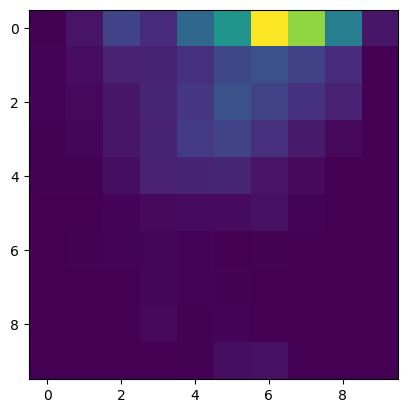

In [100]:
conv_df = best_conv_cors
conv_df = conv_df.loc[(conv_df['model1']!=conv_df['model2'])&(conv_df["prep1"]==conv_df["prep2"])]
if "m1_layer" in conv_df.columns:
    conv_df["layer"] = conv_df["m1_layer"]
    conv_df["chan"] = conv_df["chan1"]
    del conv_df["m1_layer"]
    del conv_df["chan1"]

vs_df = best_cross_cors.merge(conv_df, left_on=["save_folder", "layer", "chan"], right_on=["save_folder","layer","chan"], how="inner")
dups = ["cell_file", "cell_idx", "save_folder", "model2"]
vs_df = vs_df.sort_values(by="cor_x", ascending=False).drop_duplicates(dups).reset_index(drop=True)
img = np.histogram2d(vs_df["cor_x"], vs_df["cor_y"], bins=10)
plt.imshow(np.flip(img[0].T, axis=0))
#fig = plt.figure(figsize=(10,7))
##sns.scatterplot(x="cor_x", y="cor_y", data=vs_df, color="black")
#sns.displot(x="cor_x", y="cor_y", data=vs_df, color="black", bw_adjust=.5)
#plt.xlabel("Intr-Model Correlation", fontsize=35)
#plt.ylabel("Model-Model Correlation", fontsize=35)
#plt.title("Within Prep", fontsize=40)
#plt.xticks([i*0.1 for i in range(0,11,5)], fontsize=30)
#plt.yticks([i*0.1 for i in range(5,11,5)], fontsize=30)
#plt.ylim([0,1.15])
#plt.show()

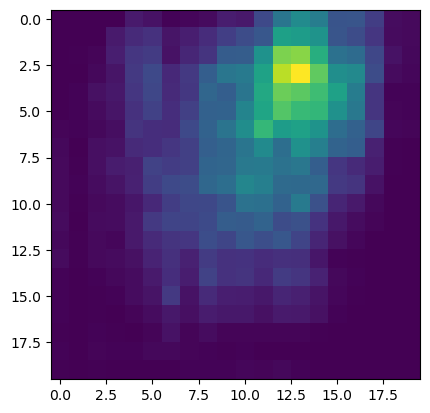

In [101]:
conv_df = best_conv_cors
conv_df = conv_df.loc[(conv_df['model1']!=conv_df['model2'])&(conv_df["prep1"]!=conv_df["prep2"])]
if "m1_layer" in conv_df.columns:
    conv_df["layer"] = conv_df["m1_layer"]
    conv_df["chan"] = conv_df["chan1"]
    del conv_df["m1_layer"]
    del conv_df["chan1"]

vs_df = best_cross_cors.merge(conv_df, left_on=["save_folder", "layer", "chan"], right_on=["save_folder","layer","chan"], how="inner")
dups = ["cell_file", "cell_idx", "save_folder", "model2"]
vs_df = vs_df.sort_values(by="cor_x", ascending=False).drop_duplicates(dups).reset_index(drop=True)
img = np.histogram2d(vs_df["cor_x"], vs_df["cor_y"], bins=20)
plt.imshow(np.flip(img[0].T, axis=0))

#fig = plt.figure(figsize=(10,7))
#sns.regplot(x="cor_x", y="cor_y", data=vs_df, color="black")
#plt.xlabel("Intr-Model Correlation", fontsize=35)
#plt.ylabel("Model-Model Correlation", fontsize=35)
#plt.title("Different Prep", fontsize=40)
#plt.xticks([i*0.1 for i in range(0,11,5)], fontsize=30)
#plt.yticks([i*0.1 for i in range(5,11,5)], fontsize=30)
#plt.show()

# No Averaging

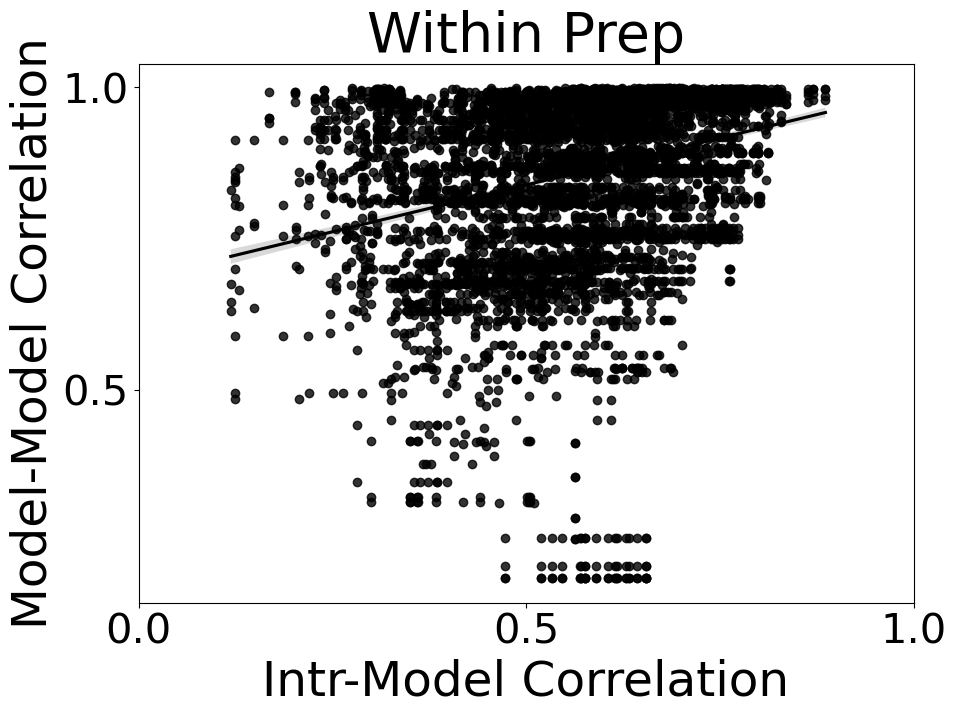

In [102]:
conv_df = best_conv_cors
conv_df = conv_df.loc[(conv_df['model1']!=conv_df['model2'])&(conv_df["prep1"]==conv_df["prep2"])]
if "m1_layer" in conv_df.columns:
    conv_df["layer"] = conv_df["m1_layer"]
    conv_df["chan"] = conv_df["chan1"]
    del conv_df["m1_layer"]
    del conv_df["chan1"]

vs_df = best_cross_cors.merge(conv_df, left_on=["save_folder", "layer", "chan"], right_on=["save_folder","layer","chan"], how="inner")
dups = ["cell_file", "cell_idx", "save_folder", "model2"]
vs_df = vs_df.sort_values(by="cor_x", ascending=False).drop_duplicates(dups).reset_index(drop=True)
fig = plt.figure(figsize=(10,7))
#sns.scatterplot(x="cor_x", y="cor_y", data=vs_df, color="black")
sns.regplot(x="cor_x", y="cor_y", data=vs_df, color="black")
plt.xlabel("Intr-Model Correlation", fontsize=35)
plt.ylabel("Model-Model Correlation", fontsize=35)
plt.title("Within Prep", fontsize=40)
plt.xticks([i*0.1 for i in range(0,11,5)], fontsize=30)
plt.yticks([i*0.1 for i in range(5,11,5)], fontsize=30)
plt.show()

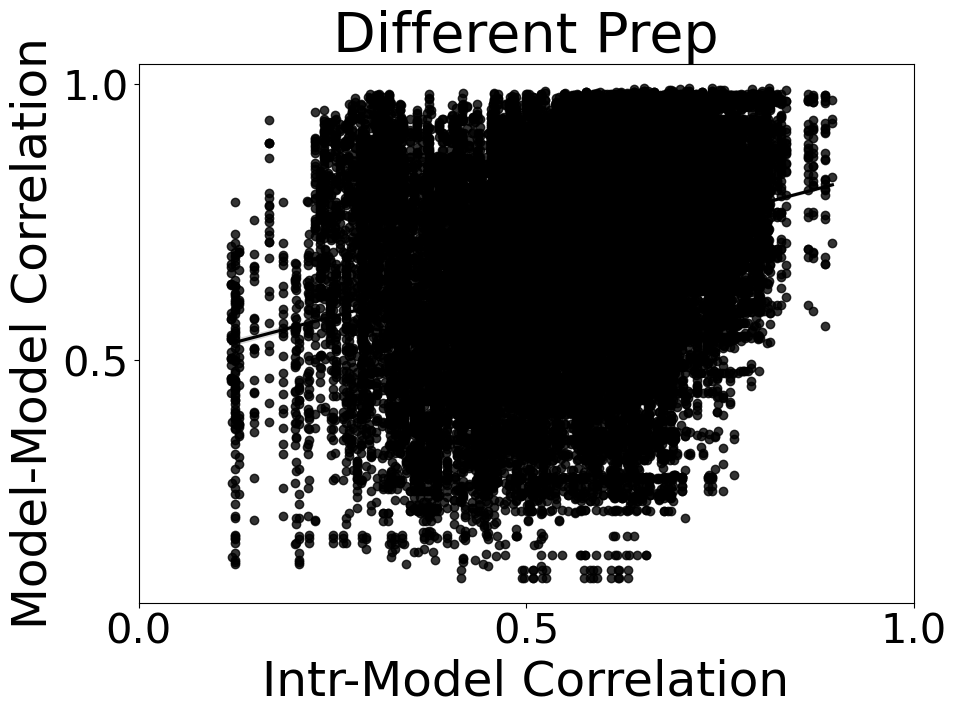

In [103]:
conv_df = best_conv_cors
conv_df = conv_df.loc[(conv_df['model1']!=conv_df['model2'])&(conv_df["prep1"]!=conv_df["prep2"])]
if "m1_layer" in conv_df.columns:
    conv_df["layer"] = conv_df["m1_layer"]
    conv_df["chan"] = conv_df["chan1"]
    del conv_df["m1_layer"]
    del conv_df["chan1"]

vs_df = best_cross_cors.merge(conv_df, left_on=["save_folder", "layer", "chan"], right_on=["save_folder","layer","chan"], how="inner")
dups = ["cell_file", "cell_idx", "save_folder", "model2"]
vs_df = vs_df.sort_values(by="cor_x", ascending=False).drop_duplicates(dups).reset_index(drop=True)
fig = plt.figure(figsize=(10,7))
sns.regplot(x="cor_x", y="cor_y", data=vs_df, color="black")
plt.xlabel("Intr-Model Correlation", fontsize=35)
plt.ylabel("Model-Model Correlation", fontsize=35)
plt.title("Different Prep", fontsize=40)
plt.xticks([i*0.1 for i in range(0,11,5)], fontsize=30)
plt.yticks([i*0.1 for i in range(5,11,5)], fontsize=30)
plt.show()

# With Averaging

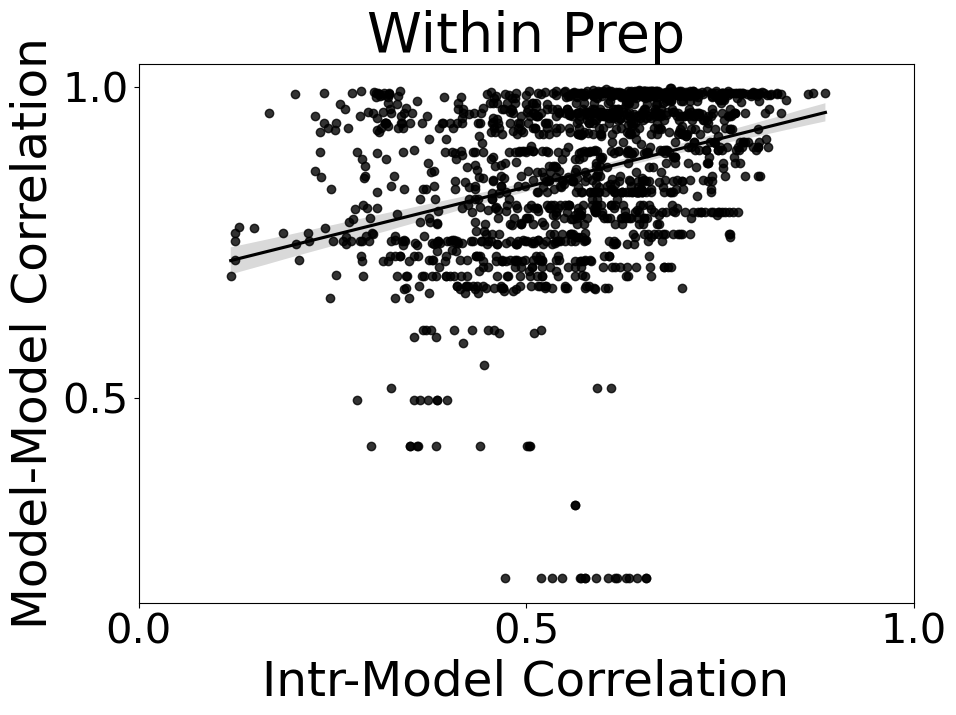

In [104]:
conv_df = best_conv_cors
conv_df = conv_df.loc[(conv_df['model1']!=conv_df['model2'])&(conv_df["prep1"]==conv_df["prep2"])]
if "m1_layer" in conv_df.columns:
    conv_df["layer"] = conv_df["m1_layer"]
    conv_df["chan"] = conv_df["chan1"]
    del conv_df["m1_layer"]
    del conv_df["chan1"]

vs_df = best_cross_cors.merge(conv_df, left_on=["save_folder", "layer", "chan"], right_on=["save_folder","layer","chan"], how="inner")
groups = ["cell_file", "cell_idx", "save_folder"]
temp = vs_df.groupby(groups).mean().reset_index()

fig = plt.figure(figsize=(10,7))
sns.regplot(x="cor_x", y="cor_y", data=temp, color="black")
plt.xlabel("Intr-Model Correlation", fontsize=35)
plt.ylabel("Model-Model Correlation", fontsize=35)
plt.title("Within Prep", fontsize=40)
plt.xticks([i*0.1 for i in range(0,11,5)], fontsize=30)
plt.yticks([i*0.1 for i in range(5,11,5)], fontsize=30)
plt.show()

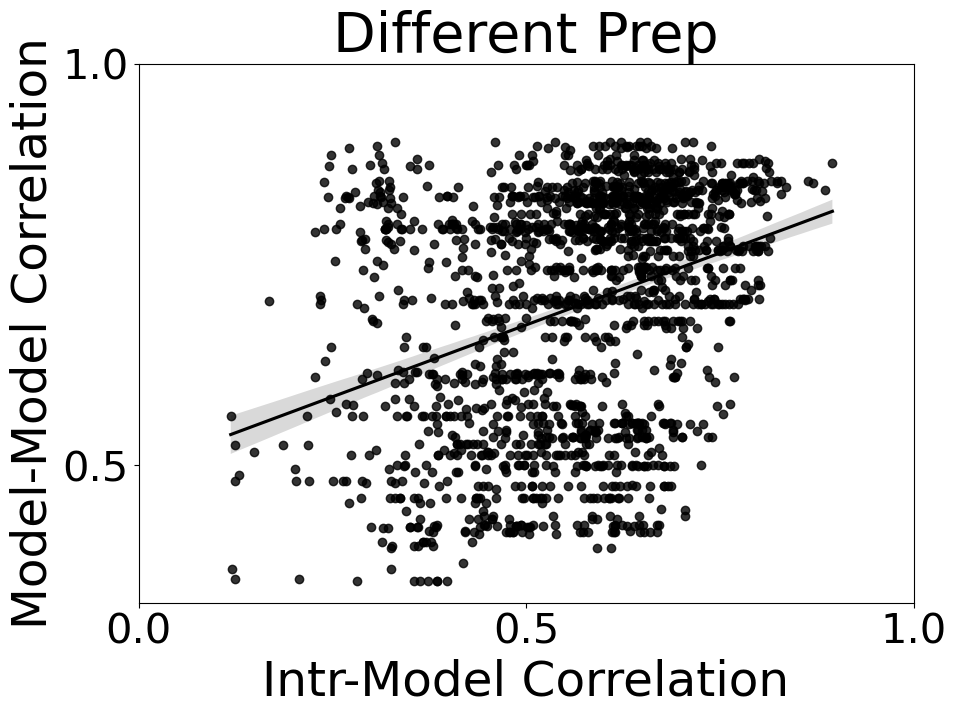

In [105]:
conv_df = best_conv_cors
conv_df = conv_df.loc[(conv_df['model1']!=conv_df['model2'])&(conv_df["prep1"]!=conv_df["prep2"])]
if "m1_layer" in conv_df.columns:
    conv_df["layer"] = conv_df["m1_layer"]
    conv_df["chan"] = conv_df["chan1"]
    del conv_df["m1_layer"]
    del conv_df["chan1"]

vs_df = best_cross_cors.merge(conv_df, left_on=["save_folder", "layer", "chan"], right_on=["save_folder","layer","chan"], how="inner")
dups = ["cell_file", "cell_idx", "save_folder", "model2"]
vs_df = vs_df.sort_values(by="cor_x", ascending=False).drop_duplicates(dups).reset_index(drop=True)
groups = ["cell_file", "cell_idx", "save_folder"]
temp = vs_df.groupby(groups).mean().reset_index()

fig = plt.figure(figsize=(10,7))
sns.regplot(x="cor_x", y="cor_y", data=temp, color="black")
plt.xlabel("Intr-Model Correlation", fontsize=35)
plt.ylabel("Model-Model Correlation", fontsize=35)
plt.title("Different Prep", fontsize=40)
plt.xticks([i*0.1 for i in range(0,11,5)], fontsize=30)
plt.yticks([i*0.1 for i in range(5,11,5)], fontsize=30)
plt.show()

# Bins

In [106]:
def bin_mu_std(x, y, bins):
    """
    Calculates the mean and std of all y values into bins based on which bin the
    corresponding x value resides in
    
    Args:
        x: ndarray (N,)
            this will be used to determine which bin the corresponding y
            value falls into
        y: ndarray (N,)
            these are the values that will be averaged over
        bins: ndarray (nBins-1,)
            these are the values that mark the edges of bins.
    """
    mus = np.zeros(bins.shape[0]+1)
    stds = np.zeros(bins.shape[0]+1)
    mus[0] = y[x<=bins[0]].mean()
    stds[0] = y[x<=bins[0]].std()
    for i in range(mus.shape[0]-2):
        mus[ i+1] = y[(x>bins[i])&(x<=bins[i+1])].mean()
        stds[i+1] = y[(x>bins[i])&(x<=bins[i+1])].std()
    mus[-1] = y[x>bins[ -1]].mean()
    stds[-1] = y[x>bins[-1]].std()
    return mus, stds

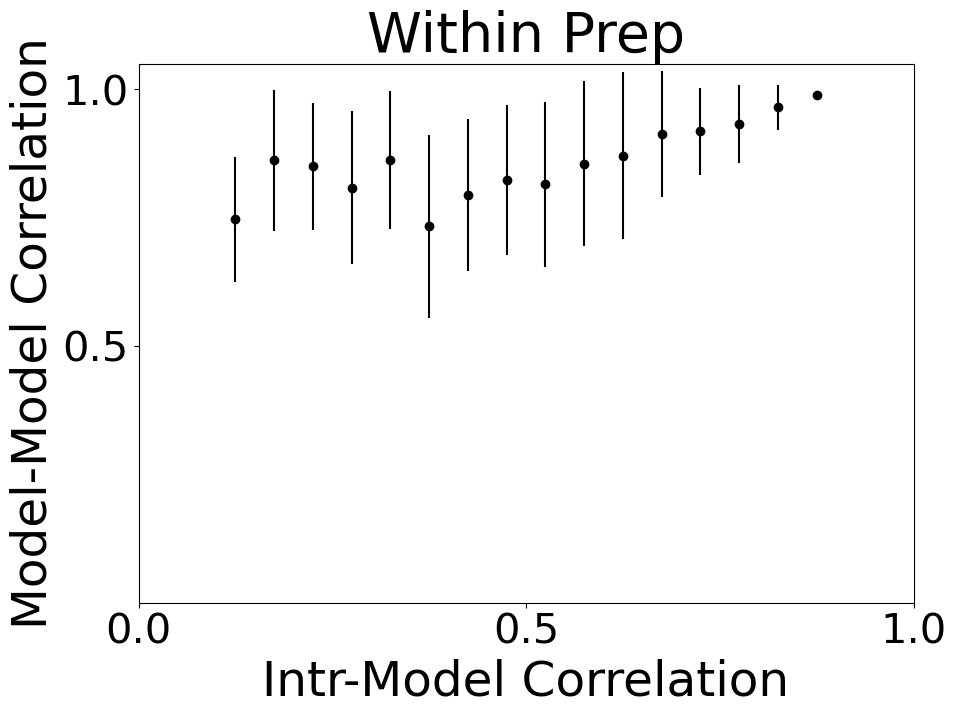

In [107]:
n_bins = 20
jitter = 0.01
bins = np.linspace(0,1,n_bins+1)[1:-1]
x_vals = np.linspace(0,1-bins[0],n_bins)+bins[0]/2

conv_df = best_conv_cors
conv_df = conv_df.loc[(conv_df['model1']!=conv_df['model2'])&(conv_df["prep1"]==conv_df["prep2"])]
if "m1_layer" in conv_df.columns:
    conv_df["layer"] = conv_df["m1_layer"]
    conv_df["chan"] = conv_df["chan1"]
    del conv_df["m1_layer"]
    del conv_df["chan1"]

vs_df = best_cross_cors.merge(conv_df, left_on=["save_folder", "layer", "chan"], right_on=["save_folder","layer","chan"], how="inner")
dups = ["cell_file", "cell_idx", "save_folder", "model2"]
vs_df = vs_df.sort_values(by="cor_x", ascending=False).drop_duplicates(dups).reset_index(drop=True)

temp = vs_df
mean, err = bin_mu_std(temp["cor_x"], temp["cor_y"], bins)
#means = dict()
#errs = dict()
#for retina in set(temp["Retina"]):
#    t = temp.loc[temp["Retina"]==retina]
#    mean, err = bin_mu_std(t["intr_cor"], t["cor"], bins)
#    means[retina] = mean
#    errs[retina] = err


fig = plt.figure(figsize=(10,7))
plt.errorbar(x_vals, mean, yerr=err, fmt='o', color="black")
#sns.regplot(x="cor_x", y="cor_y", data=vs_df, color="black")
plt.xlabel("Intr-Model Correlation", fontsize=35)
plt.ylabel("Model-Model Correlation", fontsize=35)
plt.title("Within Prep", fontsize=40)
plt.xticks([i*0.1 for i in range(0,11,5)], fontsize=30)
plt.yticks([i*0.1 for i in range(5,11,5)], fontsize=30)
plt.ylim([0,1.05])
plt.show()


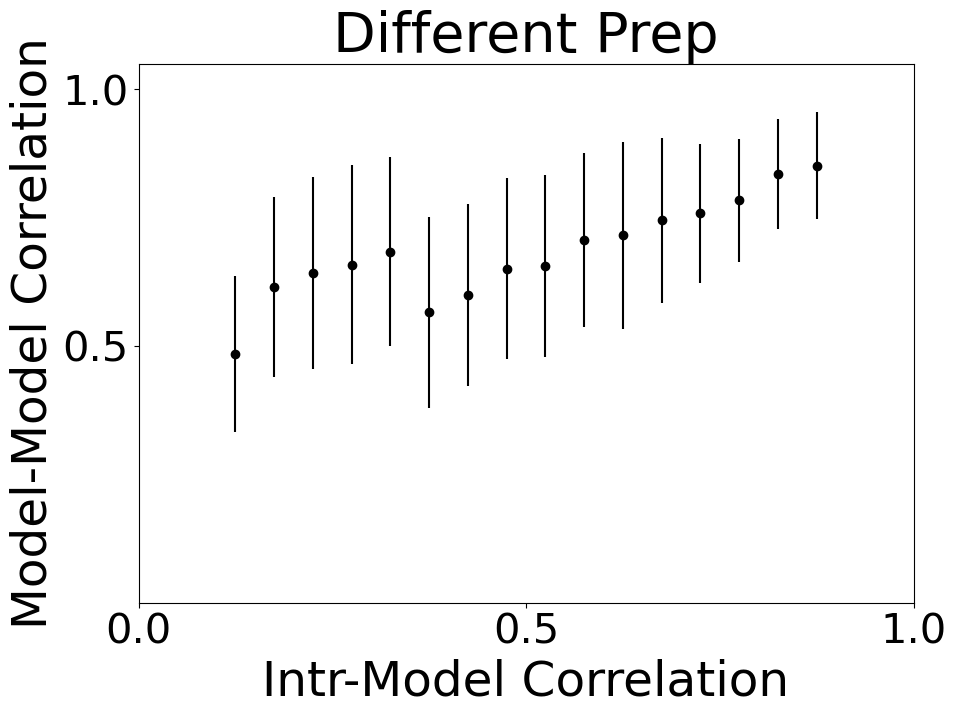

In [108]:
n_bins = 20
jitter = 0.01
bins = np.linspace(0,1,n_bins+1)[1:-1]
x_vals = np.linspace(0,1-bins[0],n_bins)+bins[0]/2

conv_df = best_conv_cors
conv_df = conv_df.loc[(conv_df['model1']!=conv_df['model2'])&(conv_df["prep1"]!=conv_df["prep2"])]
if "m1_layer" in conv_df.columns:
    conv_df["layer"] = conv_df["m1_layer"]
    conv_df["chan"] = conv_df["chan1"]
    del conv_df["m1_layer"]
    del conv_df["chan1"]

vs_df = best_cross_cors.merge(conv_df, left_on=["save_folder", "layer", "chan"], right_on=["save_folder","layer","chan"], how="inner")
dups = ["cell_file", "cell_idx", "save_folder", "model2"]
vs_df = vs_df.sort_values(by="cor_x", ascending=False).drop_duplicates(dups).reset_index(drop=True)

temp = vs_df
mean, err = bin_mu_std(temp["cor_x"], temp["cor_y"], bins)
#means = dict()
#errs = dict()
#for retina in set(temp["Retina"]):
#    t = temp.loc[temp["Retina"]==retina]
#    mean, err = bin_mu_std(t["intr_cor"], t["cor"], bins)
#    means[retina] = mean
#    errs[retina] = err


fig = plt.figure(figsize=(10,7))
plt.errorbar(x_vals, mean, yerr=err, fmt='o', color="black")
#sns.regplot(x="cor_x", y="cor_y", data=vs_df, color="black")
plt.xlabel("Intr-Model Correlation", fontsize=35)
plt.ylabel("Model-Model Correlation", fontsize=35)
plt.title("Different Prep", fontsize=40)
plt.xticks([i*0.1 for i in range(0,11,5)], fontsize=30)
plt.yticks([i*0.1 for i in range(5,11,5)], fontsize=30)
plt.ylim([0,1.05])
plt.show()



# 2d Histograms

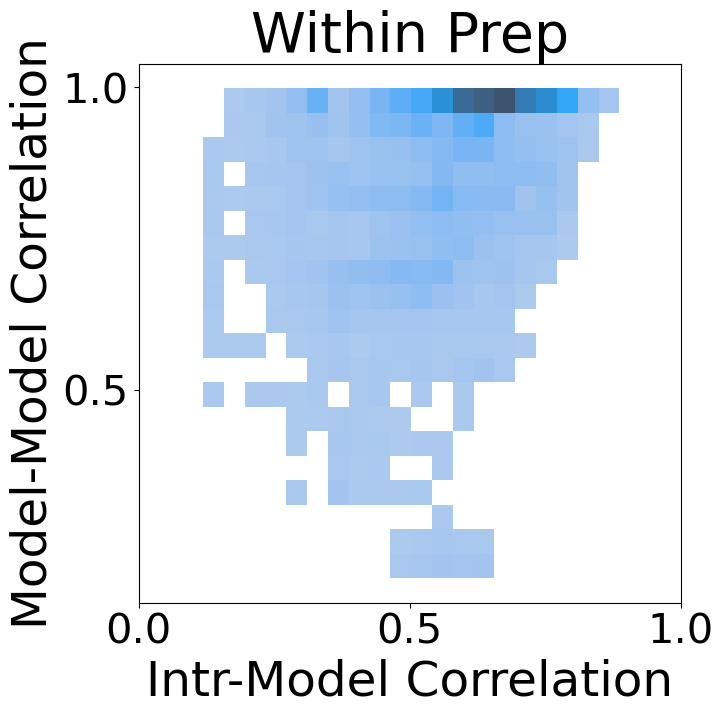

In [109]:
conv_df = best_conv_cors
conv_df = conv_df.loc[(conv_df['model1']!=conv_df['model2'])&(conv_df["prep1"]==conv_df["prep2"])]
if "m1_layer" in conv_df.columns:
    conv_df["layer"] = conv_df["m1_layer"]
    conv_df["chan"] = conv_df["chan1"]
    del conv_df["m1_layer"]
    del conv_df["chan1"]

vs_df = best_cross_cors.merge(conv_df, left_on=["save_folder", "layer", "chan"], right_on=["save_folder","layer","chan"], how="inner")
dups = ["cell_file", "cell_idx", "save_folder", "model2"]
vs_df = vs_df.sort_values(by="cor_x", ascending=False).drop_duplicates(dups).reset_index(drop=True)
fig = plt.figure(figsize=(7,7))
sns.histplot(x="cor_x", y="cor_y", data=vs_df, bins=20)
plt.xlabel("Intr-Model Correlation", fontsize=35)
plt.ylabel("Model-Model Correlation", fontsize=35)
plt.title("Within Prep", fontsize=40)
plt.xticks([i*0.1 for i in range(0,11,5)], fontsize=30)
plt.yticks([i*0.1 for i in range(5,11,5)], fontsize=30)
plt.show()

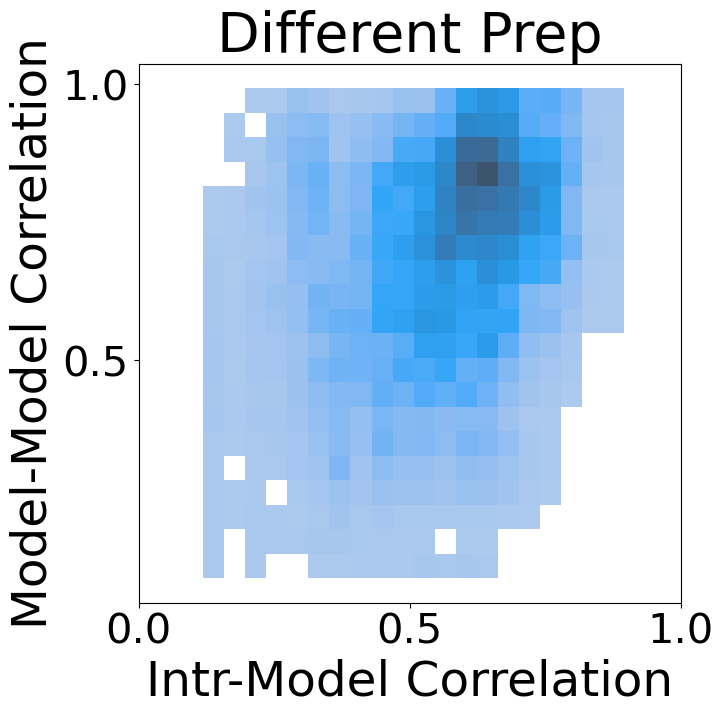

In [110]:
conv_df = best_conv_cors
conv_df = conv_df.loc[(conv_df['model1']!=conv_df['model2'])&(conv_df["prep1"]!=conv_df["prep2"])]
if "m1_layer" in conv_df.columns:
    conv_df["layer"] = conv_df["m1_layer"]
    conv_df["chan"] = conv_df["chan1"]
    del conv_df["m1_layer"]
    del conv_df["chan1"]

vs_df = best_cross_cors.merge(conv_df, left_on=["save_folder", "layer", "chan"], right_on=["save_folder","layer","chan"], how="inner")
dups = ["cell_file", "cell_idx", "save_folder", "model2"]
vs_df = vs_df.sort_values(by="cor_x", ascending=False).drop_duplicates(dups).reset_index(drop=True)
fig = plt.figure(figsize=(7,7))
sns.histplot(x="cor_x", y="cor_y", data=vs_df, stat="density", bins=20)
plt.xlabel("Intr-Model Correlation", fontsize=35)
plt.ylabel("Model-Model Correlation", fontsize=35)
plt.title("Different Prep", fontsize=40)
plt.xticks([i*0.1 for i in range(0,11,5)], fontsize=30)
plt.yticks([i*0.1 for i in range(5,11,5)], fontsize=30)
plt.show()